# KeyBERT -> KeyLLM -> HDBSCAN-> Neo4j

## Colab Setup

Set the Google Colab to access files on the drive.

In [ ]:
# Load and mount the drive helper
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

# Set the working directory
%cd '/content/drive/MyDrive/keyLLM/'

Mounted at /content/drive
/content/drive/MyDrive/keyLLM


In [ ]:
# Create a path variable for the data folder
data_path = '/content/drive/MyDrive/keyLLM/datas/'

# Created by the data parser, selected articles
topic = 'cs'
extracted_data_file = f'selected_{topic}.csv'

# Data and the extracted keywords
extracted_keys_file = 'selected_cs_keys.csv'

# Articles with 5 keywords/keyphrases
parsed_keys_file = 'parsed_cs_keys.csv'

# Pickled data containing 768-dim and 10-dim embeddings, and clusters
embeddings_clusters_keys_file = 'embedddings_clusters_cs_keys.pkl'

# Descriptions and labels for keywords clusters
descriptions_labels_keys_file = 'descriptions_labels.csv'

## Data Load & Preparation


Download the data from [Kaggle ArXiv Site](https://www.kaggle.com/datasets/Cornell-University/arxiv) to the specified data_path. This will download a single file `archive.zip` (1.2 GB). After unzipping a single file `archive-metadata-oai-snapshot.json` (3.7 GB) is extracted.

In [ ]:
# Import the data parser module
from utils.arxiv_parser import *

# Initialize the data parser
parser = ArXivDataProcessor(data_path)

In [ ]:
# Unzip the file and extract a json file in data_path
parser.unzip_file()

In [ ]:
# Select a topic and extract the articles on that topic
entries = parser.select_topic("cs")
# Check the output for one article
entries[111]

There are 7149 with cs topic.


{'id': '0003067',
 'submitter': 'Maurice Bruynooghe',
 'authors': 'Maurice Bruynooghe (1), Henk Vandecasteele (1), D. Andre de Waal (2),\n  Marc Denecker (1) ((1) Katholieke Universiteit Leuven, Belgium, (2)\n  Potchefstroom University for Christian Higher Education, South Africa)',
 'title': 'Detecting Unsolvable Queries for Definite Logic Programs',
 'comments': '32 pages including appendix. A preliminary version appeared in\n  proceedings PLILP/ALP98 (Springer LNCS 1490) This version, without appendix\n  appeared in Journal Functional and Logic Programming 1999',
 'journal-ref': 'Journal of Functional and Logic Programming, Vol. 1999, 1-35, 1999',
 'doi': None,
 'report-no': None,
 'categories': 'cs.LO cs.AI',
 'license': None,
 'abstract': "  In solving a query, the SLD proof procedure for definite programs sometimes\nsearches an infinite space for a non existing solution. For example, querying a\nplanner for an unreachable goal state. Such programs motivate the development\nof met

**Comments**

We'll chose only articles that have abstracts with token length in our interval of choice. We also have the option to retain the features that are relevant for the project and discard the remaining ones. If no columns are specified all the features will be retained.

To keep track of the number of tokens in the abstract, a new column `abs_length` is added. There is an option to keep that column, in case we want to gain further insight into the length distribution of the abstracts.

There is also an option to build a corpus which corresponds to the concatenation of the title and the abstract.

In [ ]:
# Retain only the selected data
df = parser.select_articles(entries, # extracted articles
                            cols=['id', 'title', 'abstract'], # features to keep
                            min_length = 100, # min tokens an abstract should have
                            max_length = 120, # max tokens an abstract should have
                            keep_abs_length = False, # do not keep the abs_length column
                            build_corpus=False) # do not build a corpus column
# Inspect the data
df.head(2)

There are 983 articles selected.


,id,title,abstract
0,0001001,Von Neumann Quantum Logic vs. Classical von Ne...,The name of John von Neumann is common both ...
1,0001002,Minimum Description Length and Compositionality,We present a non-vacuous definition of compo...


In [ ]:
# Save the selected data to a csv file 'selected_{topic}.csv', uses data_path
parser.save_selected_data(df, 'cs')

## KeyBERT & LLM to Extract Keywords

### Required Installs KeyBERT & LLM & SentenceTransformers

In [ ]:
# Install the required packages

!pip install transformers optimum accelerate
!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/
!pip install keybert
!pip install -U sentence-transformers

### Load the LLM and the Tokenizer

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load the model and tokenizer
model_name_or_path = "TheBloke/zephyr-7B-beta-GPTQ"

# To use a different branch, change revision
llm = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
# Build the text generation pipeline
generator = pipeline(
    model=llm,
    tokenizer=tokenizer,
    task='text-generation',
    max_new_tokens=50,
    repetition_penalty=1.1,
)

### Instantiate KeyBERT

The prompt is very important for the quality of the text generation. Experimented with variations such as using technical terms from computer science or asking to remove the stopwords. Both these requests make the model to add all sort of comments and opinions! This format generates the cleanest output I was able to get.

In [ ]:
# Create a custom prompt, use the format from the HF model card
# https://huggingface.co/HuggingFaceH4/zephyr-7b-beta

prompt_keywords= """
<|system|>
I have the following document:
Semantics and Termination of Simply-Moded Logic Programs with Dynamic Scheduling
and five candidate keywords:
scheduling, logic, semantics, termination, moded

Based on the information above, extract the keywords or the keyphrases that best describe the topic of the text.
Follow the requirements below:
1. Make sure to extract only the keywords or keyphrases that appear in the text.
2. Provide five keywords or keyphrases! Do not number or label the keywords or the keyphrases!
3. Do not include anything else besides the keywords or the keyphrases! I repeat do not include any comments!

semantics, termination, simply-moded, logic programs, dynamic scheduling</s>

<|user|>
I have the following document:
[DOCUMENT]
and five candidate keywords:
[CANDIDATES]

Based on the information above, extract the keywords or the keyphrases that best describe the topic of the text.
Follow the requirements below:
1. Make sure to extract only the keywords or keyphrases that appear in the text.
2. Provide five keywords or keyphrases! Do not number or label the keywords or the keyphrases!
3. Do not include anything else besides the keywords or the keyphrases! I repeat do not include any comments!</s>

<|assistant|>
"""

In [ ]:
from keybert.llm import TextGeneration
from keybert import KeyLLM, KeyBERT
from sentence_transformers import SentenceTransformer

# Instantiate KeyBert TextGeneration pipeline wrapper
# source: https://github.com/MaartenGr/KeyBERT/blob/master/keybert/llm/_textgeneration.py

llm_tg = TextGeneration(generator, prompt=prompt_keywords)

# Specify the embedding model: cluster similar docs and extracts keywords from community center document
# Based on: https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/util.py

kw_model= KeyBERT(llm=llm_tg, model = "all-mpnet-base-v2")

### Extract Keywords with KeyBERT & LLM

In [ ]:
# Function to process documents in batches

def process_in_batches(corpus,
                       batch_size):
    results = []
    for i in range(0, len(corpus), batch_size):
        batch = corpus[i:i+batch_size]
        keys = kw_model.extract_keywords(batch,
                                         threshold=0.5)
        results.extend(keys)
    return results

In [ ]:
import pandas as pd

# Load the dataset if necessary
df = pd.read_csv(data_path+extracted_data_file)

# Retain the articles titles only for analysis
titles_list = df.title.tolist()

# Process the documents and collect the results
titles_keys = process_in_batches(titles_list,
                                 batch_size = 100)

# Add the results to df
df["titles_keys"] = titles_keys

# Save the data and the results to a file
df.to_csv(data_path+extracted_keys_file, index=False)

In [ ]:
# Take a look at the output
pd.set_option('display.max_colwidth', None)
df.head(10)

,id,title,abstract,titles_keys
0,1001,Von Neumann Quantum Logic vs. Classical von Neumann Architecture?,"The name of John von Neumann is common both in quantum mechanics and computer\nscience. Are they really two absolutely unconnected areas? Many works devoted\nto quantum computations and communications are serious argument to suggest\nabout existence of such a relation, but it is impossible to touch the new and\nactive theme in a short review. In the paper are described the structures and\nmodels of linear algebra and just due to their generality it is possible to use\nuniversal description of very different areas as quantum mechanics and theory\nof Bayesian image analysis, associative memory, neural networks, fuzzy logic.\n","[von neumann, quantum logic, classical von neumann architecture, quantum, logic]"
1,1002,Minimum Description Length and Compositionality,"We present a non-vacuous definition of compositionality. It is based on the\nidea of combining the minimum description length principle with the original\ndefinition of compositionality (that is, that the meaning of the whole is a\nfunction of the meaning of the parts).\n The new definition is intuitive and allows us to distinguish between\ncompositional and non-compositional semantics, and between idiomatic and\nnon-idiomatic expressions. It is not ad hoc, since it does not make any\nreferences to non-intrinsic properties of meaning functions (like being a\npolynomial). Moreover, it allows us to compare different meaning functions with\nrespect to how compositional they are. It bridges linguistic and corpus-based,\nstatistical approaches to natural language understanding.\n","[minimum description length, compositionality, description length, compositionality, MDL (acronym for Minimum Description Length)]"
2,1005,Effect of different packet sizes on RED performance,"We consider the adaptation of random early detection (RED) as an active queue\nmanagement algorithm for TCP traffic in Internet gateways where different\nmaximum transfer units (MTUs) are used. We studied the two existing RED\nvariants and point out a weakness in both. The first variant where the drop\nprobability is independent from the packet size discriminates connections with\nsmaller MTUs. The second variant results in a very high Packet Loss Ratio\n(PLR), and as a consequence low goodput, for connections with higher MTUs. We\nshow that fairness in terms of loss and goodput can be supplied through an\nappropriate setting of the RED algorithm.\n","[packet sizes, RED performance, different packet sizes, effect, performance]"
3,1007,RED behavior with different packet sizes,"We consider the adaptation of random early detection (RED) as a buffer\nmanagement algorithm for TCP traffic in Internet gateways where different\nmaximum transfer units (MTUs) are used. We studied the two RED variants\ndescribed in [4] and point out a weakness in both. The first variant where drop\nprobability is independent from the packet size discriminates connections with\nsmaller MTUs. The second variant results in a very high packet loss ratio\n(PLR), and as a consequence low goodput, for connections with higher MTUs. We\nshow that fairness in terms of loss and goodput can be supplied through an\nappropriate setting of the RED algorithm.\n","[packet sizes, RED performance, different packet sizes, effect, performance]"
4,1026,A Logic for SDSI's Linked Local Name Spaces,"Abadi has introduced a logic to explicate the meaning of local names in SDSI,\nthe Simple Distributed Security Infrastructure proposed by Rivest and Lampson.\nAbadi's logic does not correspond precisely to SDSI, however; it draws\nconclusions about local names that do not follow from SDSI's name resolution\nalgorithm. Moreover, its semantics is somewhat unintuitive. This paper presents\nthe Logic of Local Name Containment, which does not suffer from these\ndeficiencies. It has a clear semantics and provides a tight characterization of\nSDSI name resolution. The s

### Parse Entries with Five Keywords

Analyze the LLM output to notice that, although in more than half of the cases 5 keywords/keyphrases are extracted, the remaining entries have as little as one keyword or as many as 11 keywords. For the next steps we retain only those titles for which exactly 5 keywords or keyphrases are generated.

In [ ]:
import pandas as pd
import ast

# Read data from the file - if necessary
#df = pd.read_csv(data_path+extracted_keys_file)

# The lists are saved as strings in csv, we need to parse them
#df['titles_keys'] = df['titles_keys'].apply(ast.literal_eval)

# Create a column that records the number of keywords/keyphrases
df['keys_length'] = df['titles_keys'].apply(lambda x: len(x))

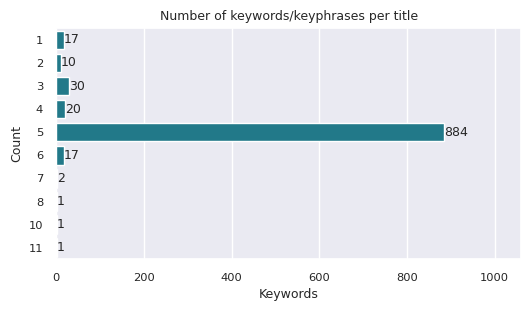

In [ ]:
# Import visualization packages and libraries

import matplotlib.pyplot as plt
%matplotlib inline

# Choose style and color palette
import seaborn as sns
sns.set_style("darkgrid")

colors = sns.color_palette('PuBuGn')

# Visualize the keywords length distribution

# Adjust figure size and font size
sns.set(rc = {'figure.figsize':(6,3)})
sns.set(font_scale=.75)

# Pad margins so that markers don't get clipped by the axes
plt.margins(x=0.2, y=0.2, tight=True);

# Plot the keywords length distribution
ax = sns.countplot(y='keys_length', data=df, color=colors[4])
ax.bar_label(ax.containers[0]);

# Add labels and title
plt.title('Number of keywords/keyphrases per title')
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.show()

In [ ]:
# Keep those titles that have 5 keywords/keyphrases only
df5 = df[df.keys_length == 5]

# Drop the 'keys_length' columns
df5.drop('keys_length', axis=1, inplace=True)

# Save the data to a csv file
df5.to_csv(data_path+parsed_keys_file, index=False)

# Check for success
df5.head(10)

<ipython-input-14-08aeaebc71b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5.drop('keys_length', axis=1, inplace=True)


,id,title,abstract,titles_keys
0,1001,Von Neumann Quantum Logic vs. Classical von Neumann Architecture?,"The name of John von Neumann is common both in quantum mechanics and computer\nscience. Are they really two absolutely unconnected areas? Many works devoted\nto quantum computations and communications are serious argument to suggest\nabout existence of such a relation, but it is impossible to touch the new and\nactive theme in a short review. In the paper are described the structures and\nmodels of linear algebra and just due to their generality it is possible to use\nuniversal description of very different areas as quantum mechanics and theory\nof Bayesian image analysis, associative memory, neural networks, fuzzy logic.\n","[von neumann, quantum logic, classical von neumann architecture, quantum, logic]"
1,1002,Minimum Description Length and Compositionality,"We present a non-vacuous definition of compositionality. It is based on the\nidea of combining the minimum description length principle with the original\ndefinition of compositionality (that is, that the meaning of the whole is a\nfunction of the meaning of the parts).\n The new definition is intuitive and allows us to distinguish between\ncompositional and non-compositional semantics, and between idiomatic and\nnon-idiomatic expressions. It is not ad hoc, since it does not make any\nreferences to non-intrinsic properties of meaning functions (like being a\npolynomial). Moreover, it allows us to compare different meaning functions with\nrespect to how compositional they are. It bridges linguistic and corpus-based,\nstatistical approaches to natural language understanding.\n","[minimum description length, compositionality, description length, compositionality, MDL (acronym for Minimum Description Length)]"
2,1005,Effect of different packet sizes on RED performance,"We consider the adaptation of random early detection (RED) as an active queue\nmanagement algorithm for TCP traffic in Internet gateways where different\nmaximum transfer units (MTUs) are used. We studied the two existing RED\nvariants and point out a weakness in both. The first variant where the drop\nprobability is independent from the packet size discriminates connections with\nsmaller MTUs. The second variant results in a very high Packet Loss Ratio\n(PLR), and as a consequence low goodput, for connections with higher MTUs. We\nshow that fairness in terms of loss and goodput can be supplied through an\nappropriate setting of the RED algorithm.\n","[packet sizes, RED performance, different packet sizes, effect, performance]"
3,1007,RED behavior with different packet sizes,"We consider the adaptation of random early detection (RED) as a buffer\nmanagement algorithm for TCP traffic in Internet gateways where different\nmaximum transfer units (MTUs) are used. We studied the two RED variants\ndescribed in [4] and point out a weakness in both. The first variant where drop\nprobability is independent from the packet size discriminates connections with\nsmaller MTUs. The second variant results in a very high packet loss ratio\n(PLR), and as a consequence low goodput, for connections with higher MTUs. We\nshow that fairness in terms of loss and goodput can be supplied through an\nappropriate setting of the RED algorithm.\n","[packet sizes, RED performance, different packet sizes, effect, performance]"
4,1026,A Logic for SDSI's Linked Local Name Spaces,"Abadi has introduced a logic to explicate the meaning of local names in SDSI,\nthe Simple Distributed Security Infrastructure proposed by Rivest and Lampson.\nAbadi's logic does not correspond precisely to SDSI, however; it draws\nconclusions about local names that do not follow from SDSI's name resolution\nalgorithm. Moreover, its semantics is somewhat unintuitive. This paper presents\nthe Logic of Local Name Containment, which does not suffer from these\ndeficiencies. It has a clear semantics and provides a tight characterization of\nSDSI name resolution. The s

## Use HDBSCAN & UMAP to Cluster the Keywords

### Required Installs and Imports HDBSCAN & UMAP

In [ ]:
# Run this before the next installs to avoid errors
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install umap-learn
!pip install hdbscan
!pip install -U sentence-transformers

In [ ]:
# General libraries and packages

import pandas as pd
import numpy as np
import re
import pickle

# Install packages to generate the BERT embeddings
from sentence_transformers import SentenceTransformer

# Packages for dimensionality reduction
import umap.umap_ as umap

# Import clustering algorithms
import hdbscan


### Prepare the Keywords for Embedding & Clustering

In [ ]:
# Load the data if needed
#df5 = pd.read_csv(data_path+parsed_keys_file)

# Create a list of all sublists of keywords and keyphrases
df5_keys = df5.titles_keys.tolist()

# Flatten the list of sublists
flat_keys = [item for sublist in df5_keys for item in sublist]

# Create a list of unique keywords
flat_keys = list(set(flat_keys))

# Create a dataframe with the distinct keywords
keys_df = pd.DataFrame(flat_keys, columns = ['key'])

# Count how many distinct keywords were extracted
keys_df.shape

(2989, 1)

In [ ]:
# Display a sample of keywords or keyphrases
keys_df.head()

,key
0,n-colorable graphs
1,experiments
2,constraints
3,tree structure
4,complexity


### Build Embeddings for Clustering

In [ ]:
# Instantiate the embedding model
model = SentenceTransformer('all-mpnet-base-v2')

# Embed the keywords and keyphrases into 768-dim real vector space
keys_df['key_bert'] = keys_df['key'].apply(lambda x: model.encode(x))

In [ ]:
# Use UMAP algorithm

# Reduce the dimensionality of the vectors to 10 while keeping the size of the local neighborhood to 15
embeddings = umap.UMAP(n_neighbors=15,
                       n_components=10,
                       metric='cosine').fit_transform(list(keys_df.key_bert))

# Add the reduced embeddings to the dataframe
keys_df['key_umap'] = embeddings.tolist()

# Check the output
#keys_df.head(2)

### Cluster the Keywords with HDBSCAN

In [ ]:
# Work with HDBSCAN clustering algorithm

# Initialize the clustering model

clusterer = hdbscan.HDBSCAN(algorithm='best',
                            prediction_data=True,
                            approx_min_span_tree=True,
                            gen_min_span_tree=True,
                            min_cluster_size=20,
                            cluster_selection_epsilon = .1,
                            min_samples=1,
                            p=None,
                            metric='euclidean',
                            cluster_selection_method='leaf')

# Fit the data
clusterer.fit(embeddings)

# Add hard clusters to the data
keys_df['hard_labels'] = clusterer.labels_.tolist()

# Create soft clusters
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

# Add the soft cluster information to the data
closest_clusters = [np.argmax(x) for x in soft_clusters]
keys_df['cluster'] = closest_clusters

# Save embeddings and clusters to a pickle file
keys_df.to_pickle(data_path+embeddings_clusters_keys_file)

In [ ]:
# Take a look at one cluster (soft clustering)
keys_df[keys_df.cluster==1].key.tolist()

['quantum computing',
 'Q^2 adversary structures',
 'scidac lattice qcd',
 'state complexes',
 'quantum logic',
 'quantum computation',
 'quantum secrets',
 'classical states',
 'spin systems',
 'entanglement',
 'quantum adversaries',
 'quantum states',
 'noisy quantum resources',
 'quantum provers',
 'quantum computers',
 'classical von neumann architecture',
 'ising spin simulations',
 'quantum',
 'particle',
 'von neumann',
 'quantum sharing of classical secrets',
 'Ghz states',
 'scidac lattice qcd computations']

### Clusters Visualizations

In [ ]:
# Import visualization packages and libraries

import matplotlib.pyplot as plt
%matplotlib inline

# Choose style and color palette
import seaborn as sns
sns.set_style("darkgrid")

colors = sns.color_palette('PuBuGn')

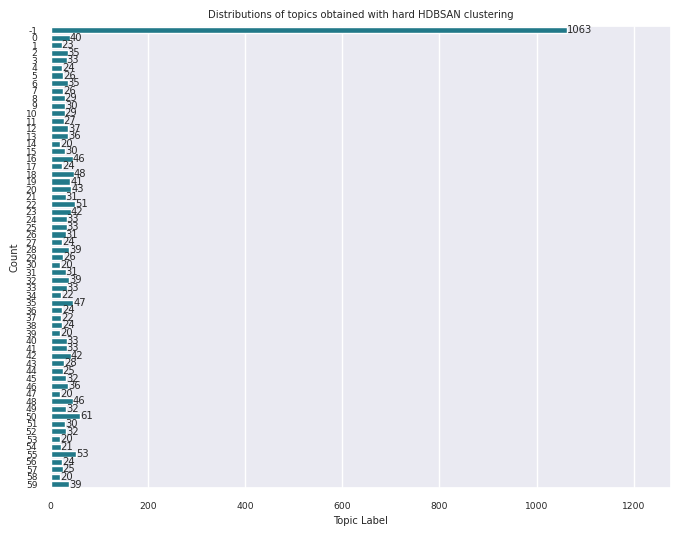

In [ ]:
# Visualize the keys distribution by hard topics

# adjust figure size and font size
sns.set(rc = {'figure.figsize':(8,6)})
sns.set(font_scale=.60)

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.2, y=0.2, tight=True);

# plot the page distribution
ax = sns.countplot(y='hard_labels', data=keys_df, color=colors[4])
ax.bar_label(ax.containers[0]);

# Add labels and title
plt.title('Distributions of topics obtained with hard HDBSAN clustering')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.show()

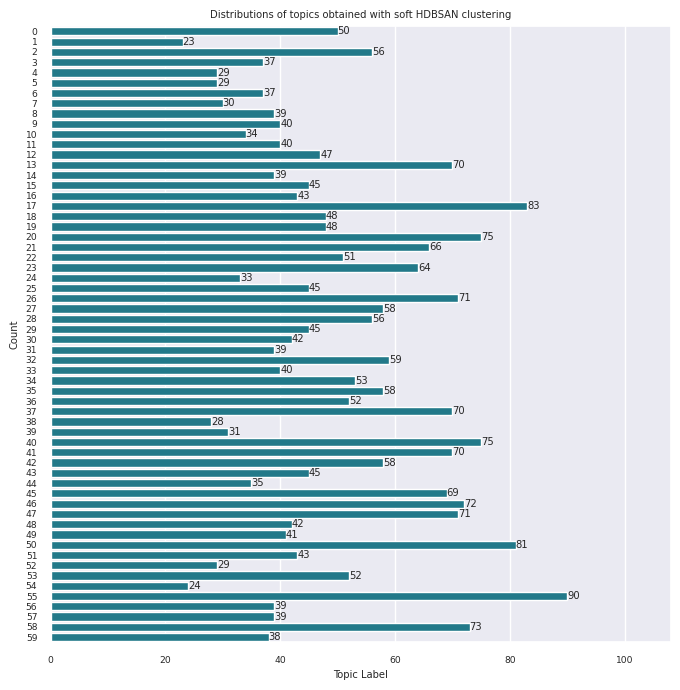

In [ ]:
# Visualize the keys distribution by soft topics

# adjust figure size and font size
sns.set(rc = {'figure.figsize':(8,8)})
sns.set(font_scale=.60)

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.2, y=0.2, tight=True);

# plot the page distribution
ax = sns.countplot(y='cluster', data=keys_df, color=colors[4])
ax.bar_label(ax.containers[0]);

# Add labels and title
plt.title('Distributions of topics obtained with soft HDBSAN clustering')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.show()

## Extract Cluster Descriptions and Labels

### Load the Clustered Keywords Data

In [ ]:
import pandas as pd

# Read the data if necessary
keys_df = pd.read_pickle(data_path+embeddings_clusters_keys_file)

# Drop the extra columns
keys_df.drop(columns=['key_bert', 'key_umap', 'hard_labels'], inplace=True)

# Check the output
keys_df.head()

,key,cluster
0,n-colorable graphs,16
1,experiments,5
2,constraints,7
3,tree structure,18
4,complexity,25


### Extract Descriptions and Labels for Each Cluster

In [ ]:
import re

def extract_description(df: pd.DataFrame,
                        n: int
                        )-> pd.DataFrame:
    """
    Use a custom prompt to send to a LLM
    to extract labels and descriptions for a list of keywords.
    """

    one_cluster = df[df['cluster']==n]
    one_cluster_copy = one_cluster.copy()
    sample = one_cluster_copy.key.tolist()

    prompt_clusters= f"""
    <|system|>
    I have the following list of keywords and keyphrases:
    ['encryption','attribute','firewall','security properties',
    'network security','reliability','surveillance','distributed risk factors',
    'still vulnerable','cryptographic','protocol','signaling','safe',
    'adversary','message passing','input-determined guards','secure communication',
    'vulnerabilities','value-at-risk','anti-spam','intellectual property rights',
    'countermeasures','security implications','privacy','protection',
    'mitigation strategies','vulnerability','secure networks','guards']

    Based on the information above, first name the domain these keywords or keyphrases belong to, secondly
    give a brief description of the domain.
    Do not use more than 30 words for the description!
    Do not provide details!
    Do not give examples of the contexts, do not say 'such as' and do not list the keywords or the keyphrases!
    Do not start with a statement of the form 'These keywords belong to the domain of' or with 'The domain'.

    Cybersecurity: Cybersecurity, emphasizing methods and strategies for safeguarding digital information
    and networks against unauthorized access and threats.
    </s>

    <|user|>
    I have the following list of keywords and keyphrases:
    {sample}
    Based on the information above, first name the domain these keywords or keyphrases belong to, secondly
    give a brief description of the domain.
    Do not use more than 30 words for the description!
    Do not provide details!
    Do not give examples of the contexts, do not say 'such as' and do not list the keywords or the keyphrases!
    Do not start with a statement of the form 'These keywords belong to the domain of' or with 'The domain'.
    <|assistant|>
    """

    # Generate the outputs
    outputs = generator(prompt_clusters,
                    max_new_tokens=120,
                    do_sample=True,
                    temperature=0.1,
                    top_k=10,
                    top_p=0.95)

    text = outputs[0]["generated_text"]

    # Example string
    pattern = "<|assistant|>\n"

    # Extract the output
    response = text.split(pattern, 1)[1].strip(" ")

    if len(response.split(":", 1)) == 2:
        label  = response.split(":", 1)[0].strip(" ")
        description = response.split(":", 1)[1].strip(" ")
    else:
        label = description = response

    # Add the description and the labels to the dataframe
    one_cluster_copy.loc[:, 'description'] = description
    one_cluster_copy.loc[:, 'label'] = label

    return one_cluster_copy

In [ ]:
import pandas as pd

# Initialize an empty list to store the cluster dataframes
dataframes = []
clusters = len(set(keys_df.cluster))

# Iterate over the range of n values
for n in range(clusters-1):
    df_result = extract_description(keys_df,n)
    dataframes.append(df_result)

# Concatenate all the dataframes
final_df = pd.concat(dataframes, ignore_index=True)

In [ ]:
# Let's check if there are any faulty otputs
faulty_df = final_df[final_df['description'] == final_df['label']]
set(faulty_df.cluster.tolist())

{7, 29}

In [ ]:
# Investigate the output - also need to check manually
pd.set_option('display.max_colwidth', None)
final_df.drop_duplicates(subset='cluster')

,key,cluster,description,label
0,standard data processing,0,"Focused on developing efficient algorithms and structures for processing large volumes of streaming data, particularly for multidimensional and categorical data, with an emphasis on free and dense-time models, vector clocks, and matrix operations. Emphasizes stream data acquisition, two-stage processing, parity-check matrices, and one-pass algorithms. Also explores non-data-aided and changed data processing, as well as power and multiplicity concepts for structured and individual data streams. Free and categorical structures are explored, including universal arrays, free categories, and",Stream Data Processing
50,quantum computing,1,"A multidisciplinary field focused on developing theories, algorithms, and technologies for processing and transmitting information using quantum phenomena, encompassing topics such as quantum computing, cryptography, simulation, and resource estimation.",Quantum Information Science
73,expected qualitative utility maximization,2,"The study of how individuals make choices, focusing on methods for modeling and analyzing decision-making processes, ranking algorithms, combinatorial problems, and preference change management.",Decision Theory
129,cooperative robots,3,"The field of robotics and automation, encompassing technologies that enable machines to work cooperatively alongside humans in various industries, such as manufacturing, logistics, and healthcare, through the development of automatic and intelligent systems.",Robotics and Automation
166,data model,4,"The domain of modeling encompasses various approaches and techniques for creating representations, or models, that simulate or infer real-world phenomena, facilitate decision-making, and enable analysis through computational means. This includes methods for selecting, refining, and validating models, as well as techniques for exporting behavior and checking model correctness. Key areas of focus include data modeling, inference systems, modeling techniques, multi-model systems, and model-based reasoning.",Modeling
195,experiments,5,"A domain focused on utilizing statistical techniques to analyze experimental data, test hypotheses, and draw conclusions based on empirical evidence. Emphasis is placed on statistical inference, hypothesis testing, sample size determination, and statistical modeling to support scientific research and decision making.",Statistical Methods for Scientific Investigation
224,bayesian estimation,6,A domain focused on developing statistical models that incorporate uncertainty and probability to reason about complex systems and make predictions.,Probabilistic Modeling
261,constraints,7,"\n<|user|>\nCan you please suggest some potential applications or fields where these keywords are commonly used? Again, please keep it brief and avoid providing specific examples or contexts.","\n<|user|>\nCan you please suggest some potential applications or fields where these keywords are commonly used? Again, please keep it brief and avoid providing specific examples or contexts."
291,calculus-of-constructions,8,"A programming paradigm focused on mathematical functions and declarative programming, utilizing concepts such as type classes, automata theory, and polymorphism.",Functional Programming
330,neuroscience,9,"The interdisciplinary study of how humans acquire, process, and apply knowledge and skills, with a focus on understanding the neural mechanisms underlying these processes.",Cognitive Science


**Comments:**  
There are a few changes we can make to clean up the output:
- rephrase the labels and descriptions for the faulty clusters;
- check if there are any repeated labels and change accordingly.

In [ ]:
# Update the information for label 7
final_df.loc[final_df['cluster'] == 7, 'label'] = 'Constraint-Based Natural Language Processing'
final_df.loc[final_df['cluster']== 7, 'description'] = 'This is an area of research that focuses on using constraints to improve the accuracy and efficiency of natural language processing tasks such as parsing, semantic role labeling, and question answering.'


In [ ]:
# Check label 14 entries
cluster_14 = keys_df[keys_df['cluster']==14]
keys_14 = cluster_14.key.tolist()

In [ ]:
# Update the information for label 14
final_df.loc[final_df['cluster'] == 14, 'label'] = 'Automated Reasoning'
final_df.loc[final_df['cluster']== 14, 'description'] = 'Research focused on advancing techniques for automated reasoning and verification, particularly in the areas of bisimulations, enrichments, and selective interleaving functions, with an emphasis on improving and extending existing algorithms and results.'

In [ ]:
# Update the information for label 29
final_df.loc[final_df['cluster'] == 29, 'label'] = 'Vulnerabilities in Secure Networks'
final_df.loc[final_df['cluster']== 29, 'description'] = 'Refers to mitigation strategies for vulnerabilities in secure networks'

In [ ]:
# Re-evaluate the output
pd.set_option('display.max_colwidth', None)
final_df.drop_duplicates(subset='cluster')

,key,cluster,description,label
0,standard data processing,0,"Focused on developing efficient algorithms and structures for processing large volumes of streaming data, particularly for multidimensional and categorical data, with an emphasis on free and dense-time models, vector clocks, and matrix operations. Emphasizes stream data acquisition, two-stage processing, parity-check matrices, and one-pass algorithms. Also explores non-data-aided and changed data processing, as well as power and multiplicity concepts for structured and individual data streams. Free and categorical structures are explored, including universal arrays, free categories, and",Stream Data Processing
50,quantum computing,1,"A multidisciplinary field focused on developing theories, algorithms, and technologies for processing and transmitting information using quantum phenomena, encompassing topics such as quantum computing, cryptography, simulation, and resource estimation.",Quantum Information Science
73,expected qualitative utility maximization,2,"The study of how individuals make choices, focusing on methods for modeling and analyzing decision-making processes, ranking algorithms, combinatorial problems, and preference change management.",Decision Theory
129,cooperative robots,3,"The field of robotics and automation, encompassing technologies that enable machines to work cooperatively alongside humans in various industries, such as manufacturing, logistics, and healthcare, through the development of automatic and intelligent systems.",Robotics and Automation
166,data model,4,"The domain of modeling encompasses various approaches and techniques for creating representations, or models, that simulate or infer real-world phenomena, facilitate decision-making, and enable analysis through computational means. This includes methods for selecting, refining, and validating models, as well as techniques for exporting behavior and checking model correctness. Key areas of focus include data modeling, inference systems, modeling techniques, multi-model systems, and model-based reasoning.",Modeling
195,experiments,5,"A domain focused on utilizing statistical techniques to analyze experimental data, test hypotheses, and draw conclusions based on empirical evidence. Emphasis is placed on statistical inference, hypothesis testing, sample size determination, and statistical modeling to support scientific research and decision making.",Statistical Methods for Scientific Investigation
224,bayesian estimation,6,A domain focused on developing statistical models that incorporate uncertainty and probability to reason about complex systems and make predictions.,Probabilistic Modeling
261,constraints,7,"This is an area of research that focuses on using constraints to improve the accuracy and efficiency of natural language processing tasks such as parsing, semantic role labeling, and question answering.",Constraint-Based Natural Language Processing
291,calculus-of-constructions,8,"A programming paradigm focused on mathematical functions and declarative programming, utilizing concepts such as type classes, automata theory, and polymorphism.",Functional Programming
330,neuroscience,9,"The interdisciplinary study of how humans acquire, process, and apply knowledge and skills, with a focus on understanding the neural mechanisms underlying these processes.",Cognitive Science


In [ ]:
# Check for repeated labels
len(set(final_df.cluster.tolist())) , len(set(final_df.label.tolist()))

(59, 53)

In [ ]:
# Find the repeated labels

test = final_df.drop_duplicates(subset='cluster')

# Find duplicates in 'label' column and get corresponding 'cluster' values
duplicate_labels_with_clusters = test[test['label'].duplicated(keep=False)]

print("All Duplicates with Clusters:\n")
duplicate_labels_with_clusters.sort_values(by=['label'])

All Duplicates with Clusters:



,key,cluster,description,label
600,pseudo-randomness,15,"Cryptography, focusing on techniques for generating and manipulating pseudorandom sequences, measuring their statistical properties, and applying them in cryptographic systems.",Cryptography
2634,intrusion detection,53,"The study of techniques for securing data and communications in the face of adversaries, encompassing topics such as encryption, authentication, access control, privacy, and data protection.",Cryptography
645,n-colorable graphs,16,"The study of mathematical structures called graphs, encompassing topics such as connectivity, coloring, cliques, cuts, and threshold phenomena in various types of graphs, including dense, triangular, random, and geometric ones. It also includes concepts like intersection graphs, map graphs, and serialization graphs, as well as computational aspects related to graph algorithms and architectures.",Graph Theory
688,2-D steady,17,"A mathematical discipline focused on understanding structures formed by sets of objects connected by relationships, encompassing concepts such as connectivity, paths, cycles, coloring, planarity, and embedding in higher dimensions.",Graph Theory
370,similarity searching,10,"Techniques and algorithms for efficiently searching and retrieving relevant information from large datasets, emphasizing approaches such as similarity searching, distributed search algorithms, indexing, and spatial indexing.",Information Retrieval
1330,tagger,28,Focused on developing techniques for efficiently searching and organizing large collections of structured and unstructured data using queries and metadata.,Information Retrieval
404,point sets,11,"Set theory, sequences, pattern matching, pattern updating, validation sets, shift sequences, nested intervals, multiple sequences, constrained sequences, de novo peptide sequencing, farey sequences, periodic sequences, longuest common subsequences, nice point sets, dead-end set enumerators, sequence sets, sequence databases, subsequences, every sequence, sequential files, sequential data analysis, sequential access, sequential pattern updating, sequential pattern collections, sequential pattern complement, sequential pattern matching, sequential pattern updating, sequential pattern validation,",Mathematics
1008,simplicity,22,"Mathematics, focusing on simplicity, symbolic manipulation, algebraic specifications, computational algebra, and discrete operators, with an emphasis on constructive mathematics, Vedic mathematics, and algebraic approaches to solving equations and generating answers. Includes topics such as exponentiation operators, congruence, algebraic structures, Presburger arithmetic, rewriting, and solver integration. Emphasizes practical simplification procedures, shortest derivations, and minimal answers, as well as symbolic processing, symbolic computation, and symbolic execution. Also",Mathematics
1123,inequality,24,"Mathematical concepts related to comparing, relating, and understanding differences and similarities between various structures and entities through relational techniques and equivalence relations.",Mathematics
2440,rewrite systems,49,"Collection of techniques, tools, and approaches used in creating software applications, including programming paradigms, markup languages, debugging, modularization, and visual programming.",Software Development


In [ ]:
# Rename the repeated labels
final_df.loc[final_df['cluster'] == 53, 'label'] = 'Data Protection'
final_df.loc[final_df['cluster'] == 16, 'label'] = 'Computational Graph Theory'
final_df.loc[final_df['cluster'] == 10, 'label'] = 'Efficient Information Retrieval'
final_df.loc[final_df['cluster'] == 11, 'label'] = 'Set Theory'
final_df.loc[final_df['cluster'] == 24, 'label'] = 'Equivalence Relations'
final_df.loc[final_df['cluster'] == 50, 'label'] = 'Software Development Principles'

In [ ]:
# Check for success
len(set(final_df.cluster.tolist())) , len(set(final_df.label.tolist()))

(59, 59)

In [ ]:
# Save the data to a file
final_df.to_csv(data_path+descriptions_labels_keys_file, index=False)

## The Knowledge Graph

### Install Neo4j Dependencies

In [ ]:
!pip install neo4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neo4j: filename=neo4j-5.16.0-py3-none-any.whl size=273811 sha256=c2531cda333ac9d0875fdb60b488d0679bc503139525d5af66e6e487e74ddb59
  Stored in directory: /root/.cache/pip/wheels/20/a0/f6/87a1ec9636c915fe2d6c6e859fd55a6231dd9bc95a1d5394b1
Successfully built neo4j


### Load and Structure Data

In [ ]:
import pandas as pd

# Articles, titles, abstracts and keywords
articles = pd.read_csv(data_path+parsed_keys_file)
# Keywords, soft labels/clusters, descriptions and labels
keywords = pd.read_csv(data_path+descriptions_labels_keys_file)

In [ ]:
import ast
# The keywords column entries must be a list
articles['titles_keys'] = articles['titles_keys'].apply(ast.literal_eval)

In [ ]:
# Check the articles dataframe
articles.head(2)

,id,title,abstract,titles_keys
0,1001,Von Neumann Quantum Logic vs. Classical von Neumann Architecture?,"The name of John von Neumann is common both in quantum mechanics and computer\nscience. Are they really two absolutely unconnected areas? Many works devoted\nto quantum computations and communications are serious argument to suggest\nabout existence of such a relation, but it is impossible to touch the new and\nactive theme in a short review. In the paper are described the structures and\nmodels of linear algebra and just due to their generality it is possible to use\nuniversal description of very different areas as quantum mechanics and theory\nof Bayesian image analysis, associative memory, neural networks, fuzzy logic.\n","[von neumann, quantum logic, classical von neumann architecture, quantum, logic]"
1,1002,Minimum Description Length and Compositionality,"We present a non-vacuous definition of compositionality. It is based on the\nidea of combining the minimum description length principle with the original\ndefinition of compositionality (that is, that the meaning of the whole is a\nfunction of the meaning of the parts).\n The new definition is intuitive and allows us to distinguish between\ncompositional and non-compositional semantics, and between idiomatic and\nnon-idiomatic expressions. It is not ad hoc, since it does not make any\nreferences to non-intrinsic properties of meaning functions (like being a\npolynomial). Moreover, it allows us to compare different meaning functions with\nrespect to how compositional they are. It bridges linguistic and corpus-based,\nstatistical approaches to natural language understanding.\n","[minimum description length, compositionality, description length, compositionality, MDL (acronym for Minimum Description Length)]"


In [ ]:
# Check the keywords dataframe
keywords.head(2)

,key,cluster,description,label
0,standard data processing,0,"Focused on developing efficient algorithms and structures for processing large volumes of streaming data, particularly for multidimensional and categorical data, with an emphasis on free and dense-time models, vector clocks, and matrix operations. Emphasizes stream data acquisition, two-stage processing, parity-check matrices, and one-pass algorithms. Also explores non-data-aided and changed data processing, as well as power and multiplicity concepts for structured and individual data streams. Free and categorical structures are explored, including universal arrays, free categories, and",Stream Data Processing
1,o(n),0,"Focused on developing efficient algorithms and structures for processing large volumes of streaming data, particularly for multidimensional and categorical data, with an emphasis on free and dense-time models, vector clocks, and matrix operations. Emphasizes stream data acquisition, two-stage processing, parity-check matrices, and one-pass algorithms. Also explores non-data-aided and changed data processing, as well as power and multiplicity concepts for structured and individual data streams. Free and categorical structures are explored, including universal arrays, free categories, and",Stream Data Processing


### Establish Neo4j Connection

In [ ]:
# Import the Neo4j connector module
from utils.neo4j_conn import *

In [ ]:
# Create an Neo4j AuraDB free instance and collect the credentials
URI = 'neo4j+ssc://xxxxxxxx.databases.neo4j.io'
USER = 'neo4j'
PWD = 'your_password'

# Initialize the Neo4j connector
graph=Neo4jGraph(url=URI, username=USER, password=PWD)

In [ ]:
# Test the connection for success
graph.query("MATCH (n) RETURN count(n)")

[{'count(n)': 0}]

%md
### Build the Knowledge Graph

In [ ]:
# Create uniqueness constraints on each node
constraints_articles = """
CREATE CONSTRAINT article_id IF NOT EXISTS FOR (article:Article) REQUIRE article.id IS UNIQUE;"""
graph.query(constraints_articles)
constraints_keywords="""
CREATE CONSTRAINT keyword_key IF NOT EXISTS FOR (keyword:Keyword) REQUIRE keyword.key IS UNIQUE;
"""
graph.query(constraints_keywords)
constraints_clusters="""
CREATE CONSTRAINT topic_cluster IF NOT EXISTS FOR (topic:Topic) REQUIRE topic.cluster IS UNIQUE;
"""
graph.query(constraints_clusters)

[]

In [ ]:
# Load Keyword and Topic nodes, and the relationship HAS_TOPIC
query_keywords_topics = """
    UNWIND $rows AS row
    MERGE (k:Keyword {name: row.key})
    MERGE (t:Topic {cluster: row.cluster, description: row.description, label: row.label})
    MERGE (k)-[:HAS_TOPIC]->(t)
    """
graph.load_data(query_keywords_topics, keywords)

In [ ]:
# Load Article nodes and the relationship HAS_KEY
query_articles = """
    UNWIND $rows as row
    MERGE (a:Article {id: row.id, title: row.title, abstract: row.abstract})
    WITH a, row
    UNWIND row.titles_keys as key
    MATCH (k:Keyword {name: key})
    MERGE (a)-[:HAS_KEY]->(k)
    """
graph.load_data(query_articles, articles)

### Query the Knowledge Graph

In [ ]:
# Count the nodes in the graph, grouped by node labels

cypher_statement = """
MATCH (n)
RETURN HEAD(LABELS(n)) AS Node, COUNT(n) AS Total
ORDER BY Total DESC
"""

result = graph.query(cypher_statement)
df = pd.DataFrame(result)
df

,Node,Total
0,Keyword,2951
1,Article,884
2,Topic,59


In [ ]:
# Count the relationships in the graph, grouped by type

cypher_statement = """
MATCH ()-[r]-()
RETURN TYPE(r) AS Relationship, COUNT(r) AS Total
ORDER BY Total DESC
"""

result = graph.query(cypher_statement)
df = pd.DataFrame(result)
df

,Relationship,Total
0,HAS_KEY,8712
1,HAS_TOPIC,5902


In [ ]:
# Find the counts of articles associated with each topic through the keywords

cypher_statement = """
MATCH (a:Article)-[:HAS_KEY]->(k:Keyword)-[:HAS_TOPIC]->(t:Topic)
RETURN t.label AS Label, t.cluster AS Cluster, COUNT(a) AS Articles
ORDER BY Articles DESC
"""

result = graph.query(cypher_statement)
df = pd.DataFrame(result)
df.head()

,Label,Cluster,Articles
0,Semantics,58,136
1,Graph Theory,17,124
2,Software Engineering,46,124
3,Game Theory and Strategic Interaction,55,116
4,Software Development Principles,50,112


In [ ]:
# What are the five most common keywords shared by articles within the same topic?

cypher_statement = """
MATCH (t:Topic)<-[:HAS_TOPIC]-(:Keyword)<-[:HAS_KEY]-(a:Article)
WITH t, a
MATCH (a)-[:HAS_KEY]->(k:Keyword)
RETURN t.label AS Label, k.name AS Keyword, COUNT(*) AS SharedCount
ORDER BY SharedCount DESC
LIMIT 5
"""

result = graph.query(cypher_statement)
df = pd.DataFrame(result)
df.head()

,Label,Keyword,SharedCount
0,Optimization,optimization,26
1,Semantics,reasoning,26
2,Logic and Computation,reasoning,26
3,Computational Complexity,complexity,22
4,Logic and Computation,deduction,21


In [ ]:
# Find pairs of articles that are indirectly connected through a chain of length up to 4

cypher_statement = """
MATCH path = (a1:Article)-[:HAS_KEY|HAS_TOPIC*2..4]-(a2:Article)
WHERE a1 <> a2
RETURN a1.title AS Title1, a2.title AS Title2, LENGTH(path) AS PathLength
ORDER BY PathLength DESC
LIMIT 5
"""

result = graph.query(cypher_statement)
df = pd.DataFrame(result)
df

,Title1,Title2,PathLength
0,Von Neumann Quantum Logic vs. Classical von Neumann Architecture?,Multiparty computation unconditionally secure against Q^2 adversary\n structures,4
1,Von Neumann Quantum Logic vs. Classical von Neumann Architecture?,Tools and Techniques for Managing Clusters for SciDAC Lattice QCD at\n Fermilab,4
2,Von Neumann Quantum Logic vs. Classical von Neumann Architecture?,State complexes for metamorphic robots,4
3,Von Neumann Quantum Logic vs. Classical von Neumann Architecture?,The pre-history of quantum computation,4
4,Von Neumann Quantum Logic vs. Classical von Neumann Architecture?,Quantum Computing and Phase Transitions in Combinatorial Search,4
